# Extracting roadside ditches using Whitebox Tools and Python

#### Conceptual Method
1) Applies a Difference-from-Mean Elevation (DFME) filter to an input DEM.
2) Thresholds the DFME raster to extract grid cells where DFME < -0.15.
3) Buffers a road vector layer to create a road mask.
4) Converts the buffered road vector to a raster matching the DEM resolution and extent.
5) Multiplies the road buffer raster by the thresholded DFME raster to isolate ditches near roads.

#### Inputs
1) User-defined elevation raster

#### Outputs
1) dfme.tif: Difference-from-Mean Elevation raster.
2) dfme_thresholded.tif: Raster showing areas below -0.15 DFME.
3) roads_buffered.shp: Buffered road vector.
4) road_mask.tif: Rasterized road buffer.
5) final_result.tif: Output raster highlighting ditches near roads.

Imports

In [7]:
import sys
from pathlib import Path
utils_path = Path(r'C:\Users\ah5766\AppData\Local\anaconda3\envs\geo\Lib\site-packages')
sys.path.append(str(utils_path))

In [5]:
import os
import whitebox
import whitebox_workflows
from whitebox_workflows import WbEnvironment, show, WbPalette
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import rasterize
import numpy as np
import pathlib 
from datetime import datetime
import matplotlib.pyplot as plt
#import utils as proj_utils

%matplotlib widget


Utility Functions

In [6]:
from pathlib import Path

def setup_project_directories(base_dir=None):
    """
    Creates a structured project directory with default folders. Ensures existing directories 
    with data are not overwritten. Returns a dictionary of created directories.

    Parameters:
    - base_dir (str or Path, optional): Path to the base directory. If None, asks user for input.

    Returns:
    - dict: Dictionary containing the paths of created directories.
    """

    # Assign or ask for base directory
    if base_dir is None:
        base_dir = input(f"Enter the base directory (default: {Path.cwd()}): ").strip()
        base_dir = Path(base_dir) if base_dir else Path.cwd()
    else:
        base_dir = Path(base_dir)

    # Validate path
    if not base_dir.exists():
        print(f" Warning: The specified base directory does not exist. Creating it at: {base_dir}")
        base_dir.mkdir(parents=True, exist_ok=True)

    # Define useful subdirectories
    subdirs = {
        "Data": base_dir / "data",
        "Raw Data": base_dir / "data" / "raw",
        "Processed Data": base_dir / "data" / "processed",
        "Output": base_dir / "output",
        "Figures": base_dir / "output" / "figures",
        "Logs": base_dir / "logs",
        "Config": base_dir / "config",
        "Scripts": base_dir / "scripts",
        "Notebooks": base_dir / "notebooks",
        "Reports": base_dir / "reports",
    }

    # Track created directories
    created_dirs = {}

    # Create directories safely
    for name, path in subdirs.items():
        if path.exists() and any(path.iterdir()):  # Check if directory exists and has files
            print(f"Warning: '{name}' directory already exists and contains data. Skipping creation.")
        else:
            path.mkdir(parents=True, exist_ok=True)
            created_dirs[name] = path  # Store successfully created directories

    # Print Summary
    print(f"Base Directory: {base_dir.resolve()}\n")

    for name, path in subdirs.items():
        status = "✅ Created" if name in created_dirs else "⚠️ Exists (Not Modified)"
        print(f"   📁 {name}: {path.relative_to(base_dir)}  - {status}")

    print("\n Setup complete!")

    '''
    # Example Usage
    project_dirs = setup_project_directories("/Users/yourname/projects")

    # Use returned dictionary for path references
    dem_path = project_dirs["Data"] / "input_dem.tif"
    print(f"\nDEM will be stored in: {dem_path}")
    '''
    return subdirs  # Return the full dictionary of directories




In [7]:
project_dirs = setup_project_directories(r'\Users\ah5766\OneDrive - Halff\Documents\Code\proj\wbt_lp_2025')

Base Directory: C:\Users\ah5766\OneDrive - Halff\Documents\Code\proj\wbt_lp_2025

   📁 Data: data  - ⚠️ Exists (Not Modified)
   📁 Raw Data: data\raw  - ⚠️ Exists (Not Modified)
   📁 Processed Data: data\processed  - ⚠️ Exists (Not Modified)
   📁 Output: output  - ⚠️ Exists (Not Modified)
   📁 Figures: output\figures  - ✅ Created
   📁 Logs: logs  - ✅ Created
   📁 Config: config  - ✅ Created
   📁 Scripts: scripts  - ✅ Created
   📁 Notebooks: notebooks  - ✅ Created
   📁 Reports: reports  - ✅ Created

 Setup complete!


In [ ]:
# Initialize Whitebox Workflows
wbe = WbEnvironment()
wbe.verbose = True
wbe.available_functions()

Available Methods (LicenseType.WbW):
1. adaptive_filter                                2. add_point_coordinates_to_table
3. aggregate_raster                               4. anova
5. ascii_to_las                                   6. aspect
7. attribute_correlation                          8. attribute_histogram
9. attribute_scattergram                          10. available_functions
11. average_flowpath_slope                        12. average_normal_vector_angular_deviation
13. average_overlay                               14. average_upslope_flowpath_length
15. balance_contrast_enhancement                  16. basins
17. bilateral_filter                              18. block_maximum
19. block_minimum                                 20. bool_and
21. bool_not                                      22. bool_or
23. bool_xor                                      24. boundary_shape_complexity
25. breach_depressions_least_cost                 26. breach_single_cell_pits
27. buffer_raster    

Path

In [ ]:
## Define file paths
# DEM
dem_winpath = r"C:\Users\ah5766\DEM\livingston\USGS_one_meter_livingston_LA_Amite_2018_clip.tif"
#dem_winpath = r"C:\Users\ah5766\DEM\livingston\USGS_one_meter_livingston_LA_UpperDeltaPlain_2017_clip.tif"
#dem_winpath = r"C:\Users\ah5766\DEM\livingston\USGS_0_5m_livingston_LA_Amite_2018_resample.tif"
#dem_winpath = r"C:\Users\ah5766\DEM\livingston\USGS_0_5m_livingston_LA_UpperDeltaPlain_2017_resample.tif"
dem_path = Path(dem_winpath)
dem_name = dem_path.stem

# DEM-derived
fx=11 # Filter size
fy=11 # Filter size
dfme_path = project_dirs['Processed Data'] / f"{dem_name}_dfme_{fx}x{fy}.tif"
devfme_path = project_dirs['Processed Data'] / f"{dem_name}_devfme_{fx}x{fy}.tif"
thresholded_dfme_path = project_dirs['Processed Data'] / f"{dem_name}_dfme_{fx}x{fy}_thresholded.tif"
thresholded_devfme_path = project_dirs['Processed Data'] / f"{dem_name}_devfme_{fx}x{fy}_thresholded.tif"

# Mask
mask_vector = project_dirs['Raw Data'] / "livingston_parish.shp"
mask_path = Path(mask_vector)
mask_name = mask_path.stem
dem_clip = project_dirs['Processed Data'] / f"{dem_name}_clip.tif" 

# Roads 
road_vector = r"C:\Users\ah5766\OneDrive - Halff\Documents\FTP\tl_2024_22_prisecroads\tl_2024_22_prisecroads.shp"
road_path = Path(road_vector)
road_name = road_path.stem
buffered_road_vector_path = project_dirs['Processed Data'] / f"{road_name}_roads_buffered.shp"
road_raster_path = project_dirs['Output'] / f"{road_name}_road_mask.tif"

# Output
final_output_path = project_dirs['Output'] / f"{dem_name}_processed_result.tif"

0) Preprocessing

In [ ]:
# Read in the DEM
dem = wbe.read_raster(dem_winpath)

In [ ]:
# create a hillshade image for visualization.
hs = wbe.multidirectional_hillshade(dem, full_360_mode=True)
#wbe.write_raster(hs, 'hillshade.tif', compress=True)

In [ ]:
print(f"Rows: {dem.configs.rows}")
print(f"Columns: {dem.configs.columns}")
print(f"Resolution (x direction): {dem.configs.resolution_x}")
print(f"Resolution (y direction): {dem.configs.resolution_y}")
print(f"NoData value: {dem.configs.nodata}")
dem.update_min_max() # Find the raster min/max values
print(f"Min. value: {dem.configs.minimum}")
print(f"Max. value: {dem.configs.maximum}")
print(f"Data type: {dem.configs.data_type}")
print(f"Projection: {dem.configs.projection}")

Rows: 43346
Columns: 47178
Resolution (x direction): 1.0
Resolution (y direction): 1.0
NoData value: 3.3999999521443642e+38
Min. value: -0.8662823438644409
Max. value: 62.688194274902344
Data type: RasterDataType.F32
Projection: not specified


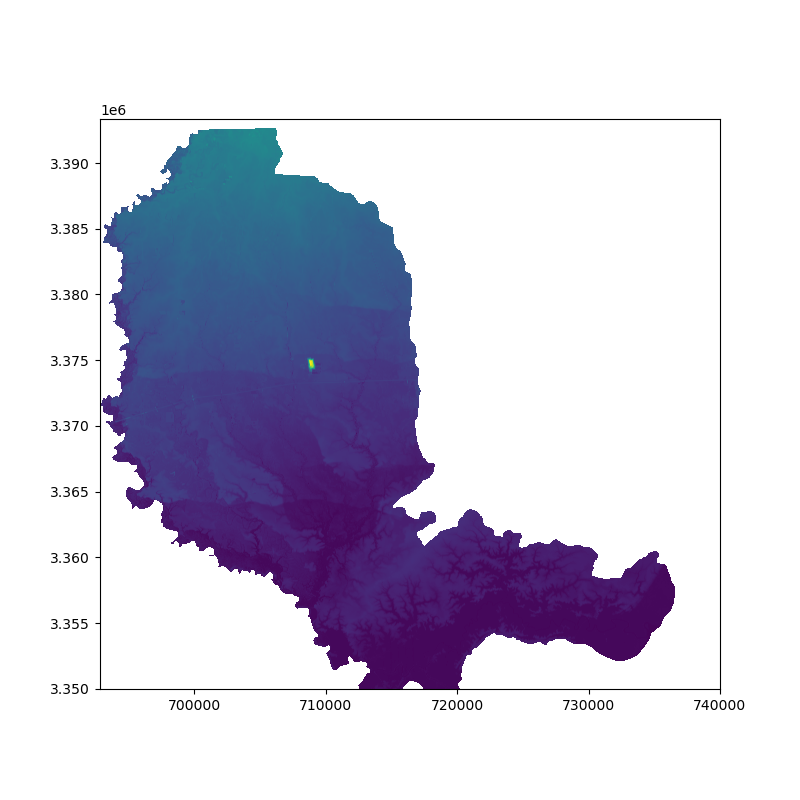

<Axes: >

In [ ]:
fig, ax = plt.subplots()

ax = show(dem, 
          ax=ax, 
          title='Livingston Parish', 
          cmap=WbPalette.Earthtones, 
          figsize=(10,7), 
          skip=2, 
          colorbar_kwargs={'label': 'Elevation (m)', 'location': "right", 'shrink': 0.5}, 
          zorder=1
          )
ax = show(hs, 
          ax=ax, 
          cmap='grey', 
          clip_percent=10.0, 
          skip=2, 
          alpha=0.15, 
          zorder=2
          )

# set axes range
ax.set_xlim([dem.configs.west, dem.configs.east])
ax.set_ylim([dem.configs.south, dem.configs.north])

ax.legend()

plt.show()


1) DFME Filtering

- Uses WhiteboxTools to compute the DFME on the DEM.
- The filter size (e.g., 11x11) can be adjusted based on the dataset.

In [ ]:
# Step 1: Apply Difference-from-Mean Elevation (DFME) Filter
dfme = wbe.difference_from_mean_elevation(dem,
                                          filter_size_x = fx,
                                          filter_size_y = fy,)

In [ ]:
wbe.write_raster(dfme, dfme_path)

2) Thresholding DFME

- Extracts all cells where DFME < -0.15 (indicating low areas, likely ditches).

In [ ]:
# Step 2: Threshold DFME Raster to Extract Low Cells
threshold_value = -0.15  # Adjust this based on DEM units

wbe.conditional_evaluation(dfme_path, 
                           thresholded_dfme_path, 
                           statement = f"value < {threshold_value}", 
                           true = dfme_path, 
                           false = None
                           )

3) Buffering Road Vector

- Uses GeoPandas to buffer the roads by 10 meters.
- Adjusts for different road widths if necessary.

In [ ]:
# Step 3: Buffer Road Vector
buffer_distance = 10  # Buffer distance in meters (adjust as needed)
roads = gpd.read_file(road_path)
roads = roads.to_crs(26915)
roads_buffered = roads.copy()
roads_buffered["geometry"] = roads.buffer(buffer_distance)
roads_buffered.to_file(buffered_road_vector_path)

4) Rasterizing Buffered Road Layer

- Converts the buffered road vector to a raster with the same resolution and extent as the DEM.
- Assigns 1 to roads and 0 elsewhere.

In [ ]:
# Step 4: Convert Buffered Road Vector to Raster
with rasterio.open(dem_path) as dem:
    meta = dem.meta.copy()
    transform = dem.transform
    width, height = dem.width, dem.height

    # Rasterize buffered road layer
    road_shapes = [(geom, 1) for geom in roads_buffered["geometry"]]
    road_raster = rasterize(
        road_shapes, out_shape=(height, width), transform=transform, fill=0, dtype="uint8"
    )

    # Save road mask raster
    with rasterio.open(road_raster_path, "w", **meta) as dst:
        dst.write(road_raster, 1)



5) Multiplying the Road Raster by the Thresholded DFME Raster

- Ensures only ditches within the buffered road area are included.

In [ ]:
# Step 5: Multiply Road Buffer Raster by Thresholded DFME Raster
with rasterio.open(thresholded_dfme_path) as dfme, rasterio.open(road_raster_path) as road:
    dfme_data = dfme.read(1)
    road_data = road.read(1)

    # Multiply both rasters
    final_result = dfme_data * road_data

    # Save the final output
    meta.update(dtype="float32")
    with rasterio.open(final_output_path, "w", **meta) as dst:
        dst.write(final_result, 1)

print("Processing complete. Final result saved as:", final_output_path)

## Dynamic thresholding approaches


| Method | Pros | Cons |
| :--- | :----: | :---: |
| *Standard Deviation Approach* | Adapts to variations in DFME values, simple to compute | May not work well for skewed distributions |
| *Percentile-Based* | Works well for varying elevation ranges | Assumes a fixed % of pixels are ditches |
| *Local Adaptive Thresholding* | Works well for large or complex terrains | Computationally expensive |
| *K-Means Clustering* | Fully data-driven, no need to specify a threshold | Requires good separation in values |

#### 1. Statistical Approach: Using Standard Deviations from the Mean
 - Instead of a fixed threshold (e.g., -0.15), you can analyze the DFME raster’s statistical distribution and set the threshold based on standard deviations.

*Why Use This?*
- It adapts to local terrain variations by defining "low areas" relative to the dataset.
- Works well when ditches are not a fixed depth across the study area.

In [ ]:
import rasterio
import numpy as np

# Load DFME Raster
dfme_path = "dfme.tif"

with rasterio.open(dfme_path) as src:
    dfme_data = src.read(1)  # Read first band
    dfme_data[dfme_data == src.nodata] = np.nan  # Ignore NoData values

# Compute mean and standard deviation of DFME
mean_dfme = np.nanmean(dfme_data)
std_dfme = np.nanstd(dfme_data)

# Define threshold dynamically (e.g., 1.5 standard deviations below mean)
dynamic_threshold = mean_dfme - 1.5 * std_dfme  # Adjust factor as needed

print(f"Dynamic Threshold for DFME: {dynamic_threshold}")

# Apply threshold
thresholded_dfme = (dfme_data < dynamic_threshold).astype("uint8")

# Save thresholded DFME raster
output_thresholded_dfme = "dfme_dynamic_thresholded.tif"
meta = src.meta.copy()
meta.update(dtype="uint8")

with rasterio.open(output_thresholded_dfme, "w", **meta) as dst:
    dst.write(thresholded_dfme, 1)

print("Saved dynamically thresholded DFME raster:", output_thresholded_dfme)


#### 2. Percentile-Based Thresholding
- Instead of relying on absolute values or standard deviations, another method is to threshold based on percentiles. This approach ensures that you extract a consistent proportion of the lowest DFME values.

*Why Use This?*
- Works well for datasets with variable z-units or different elevation ranges.
- Ensures a consistent fraction of the landscape is considered as ditches.

In [ ]:
percentile_cutoff = 5  # Extracts lowest 5% of values

# Compute the threshold using percentiles
dynamic_threshold = np.nanpercentile(dfme_data, percentile_cutoff)

print(f"Dynamic Threshold (5th percentile): {dynamic_threshold}")

# Apply threshold
thresholded_dfme = (dfme_data < dynamic_threshold).astype("uint8")

# Save raster as before
output_thresholded_dfme = "dfme_percentile_thresholded.tif"
with rasterio.open(output_thresholded_dfme, "w", **meta) as dst:
    dst.write(thresholded_dfme, 1)


#### 3. Local Adaptive Thresholding
- Instead of using a single threshold for the entire dataset, you can segment the DEM into smaller tiles or use a moving window to compute localized thresholds.

*Why Use This?*
- Adapts to local variations in elevation, making it ideal for large or heterogeneous study areas.
- More computationally intensive but useful when ditches have varying depths across the region.

In [ ]:
from skimage.filters import threshold_local

# Define block size (must be odd)
block_size = 101  # Adjust based on DEM resolution

# Compute adaptive threshold
adaptive_threshold = threshold_local(dfme_data, block_size, method='gaussian', offset=0)

# Apply threshold
thresholded_dfme = (dfme_data < adaptive_threshold).astype("uint8")

# Save raster as before
output_thresholded_dfme = "dfme_local_thresholded.tif"
with rasterio.open(output_thresholded_dfme, "w", **meta) as dst:
    dst.write(thresholded_dfme, 1)


#### 4. Using Clustering (K-Means) to Find Thresholds
- If the ditch pixels form a distinct cluster in the DFME histogram, you can use K-means clustering to separate low values from the rest.

*Why Use This?*
- Works well when ditch pixels naturally form a distinct class in the elevation difference histogram.
- No need to predefine a threshold; it finds the best cutoff automatically.

In [ ]:
from sklearn.cluster import KMeans

# Flatten and remove NaN values
valid_pixels = dfme_data[~np.isnan(dfme_data)].reshape(-1, 1)

# Perform K-Means with 3 clusters (adjust as needed)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(valid_pixels)

# Use the lowest cluster mean as threshold
dynamic_threshold = min(kmeans.cluster_centers_)[0]

print(f"Dynamic Threshold from Clustering: {dynamic_threshold}")

# Apply threshold
thresholded_dfme = (dfme_data < dynamic_threshold).astype("uint8")

# Save raster as before
output_thresholded_dfme = "dfme_kmeans_thresholded.tif"
with rasterio.open(output_thresholded_dfme, "w", **meta) as dst:
    dst.write(thresholded_dfme, 1)
